In [10]:
import networkx as nx # the main libary we will use
from networkx.algorithms import bipartite
from networkx.algorithms import community, centrality
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
%matplotlib inline 
import powerlaw
from collections import defaultdict, Counter
import itertools 
from networkx.algorithms import community
from networkx.algorithms import bipartite
from networkx.algorithms import centrality as ce
from networkx.algorithms import community as c
from IPython.display import display, HTML
from community import community_louvain
from networkx.algorithms.community import greedy_modularity_communities

In [9]:
file= 'data/Investments.xlsx'
df = pd.read_excel(file)

### Preprocess

In [97]:
df = df[['company_name','company_market','investor_name','funded_year','raised_amount_usd']]
df.rename(columns = {'company_name' : 'Company_Name', 'company_market' : 'Company_Market', 'investor_name':'Investor_Name', 'funded_year':'Funded_Year', 'raised_amount_usd':'Raised_Amount_USD'}, inplace = True)
df = df.dropna()
df = df[df.Raised_Amount_USD != 0]
df = df[df.Funded_Year>=1990]
original_df = df

In [98]:
df.head()

,Company_Name,Company_Market,Investor_Name,Funded_Year,Raised_Amount_USD
31,Knowledge Adventure,Games,William Lohse,1990,60000.0
43,Market Wire,Advertising,Hummer Winblad Venture Partners,1990,17550000.0
44,Market Wire,Advertising,Mindful Investors,1990,17550000.0
45,Market Wire,Advertising,Montreux Equity Partners,1990,17550000.0
46,Market Wire,Advertising,Osprey Ventures,1990,17550000.0


### Data exploration

In [99]:
print(f"Number of unique investors: {df['Investor_Name'].nunique()}")
print(f"Number of unique companies: {df['Company_Name'].nunique()}")
print(f"Number of unique company markets: {df['Company_Market'].nunique()}")
print(f"Number of unique years: {df['Funded_Year'].nunique()}")
print(f"Number of investments: {df.shape[0]}")

Number of unique investors: 20156
Number of unique companies: 24908
Number of unique company markets: 695
Number of unique years: 23
Number of investments: 99090


#### Building the network

In [100]:
G_weighted_directed = nx.from_pandas_edgelist(df=df,source='Investor_Name',target='Company_Name',edge_attr=True,create_using=nx.MultiDiGraph())
print('General information about the graph (all data):\n\n',nx.info(G_weighted_directed))

General information about the graph (all data):

 MultiDiGraph with 44777 nodes and 99090 edges


<ipython-input-100-5050eb5232cb>:2: DeprecationWarning: info is deprecated and will be removed in version 3.0.

  print('General information about the graph (all data):\n\n',nx.info(G_weighted_directed))


#### Split the data by years

In [ ]:
def make_graph(df):
    companies = defaultdict(set)
    investors = defaultdict(set)
    edges = []
    for _, row in df.iterrows():
        companies[row['Company_Name']].add(row['Investor_Name'])
        investors[row['Investor_Name']].add(row['Company_Name'])
        # add to edges a tuple of (company, investor, {weight: amout_usd})
        edges.append((row['Company_Name'], row['Investor_Name'], {"Weight": row['Raised_Amount_USD']} ))

    attr_dic = {x:y for x, y in zip(df['Company_Name'], df['Company_Market'])}
    attr_dic_fixed = {x:'Investors' for x in df['Investor_Name']}
    attr_dic_fixed.update(attr_dic)
    companies_edges.append(companies)
    investors_edges.append(investors)
    all_edges.append(edges)
    graph = nx.Graph()
    graph.add_edges_from(all_edges)
    nx.set_node_attributes(graph, attr_dic_fixed, name="Sector")
    return graph


def make_companies_graph(df):
    investor_names = df['Investor_Name'].unique()
    edges = []
    for company in investor_names:
        invested_in_companies = df.loc[df['Investor_Name'] == company]['Company_Name'].unique() # Get all companies invested by an investor
        if len(invested_in_companies) >=2:
            combinations =  itertools.combinations_with_replacement(invested_in_companies, 2)
            for c in combinations:
                if c[0] != c[1]:
                    edges.append(c)
    attr_dic = {x:y for x, y in zip(df['Company_Name'], df['Company_Market'])}
    graph = nx.Graph()
    graph.add_edges_from(edges)

    nx.set_node_attributes(graph, attr_dic, name="Sector")
    return graph

def make_investors_graph(df):
    company_names = df['Company_Name'].unique()
    edges = []
    for company in company_names:
        investors = df.loc[df['Company_Name'] == company]['Investor_Name'].unique() # Get all unique investors for a company
        if len(investors) >=2:
            combinations =  itertools.combinations_with_replacement(investors, 2)  # Create edges between 2 investors that invested in the same company
            for c in combinations:
                if c[0] != c[1]:
                    edges.append(c)
    graph = nx.Graph()
    graph.add_edges_from(edges)
    return graph

    # attr_dic_fixed = {x:'Investors' for x in df['Investor_Name']}
    # attr_dic_fixed.update(attr_dic)
    # companies_edges.append(companies)
    # investors_edges.append(investors)
    # all_edges.append(edges)

In [101]:
years_range = [(1990, 1994), (1995, 1999), (2000, 2004), (2005,2009), (2010, 2014)]
years_dict = {i:year_range for i,year_range in enumerate(years_range)}
df_list =[df[(df['Funded_Year'] <= year_range[1]) & (df['Funded_Year'] >= year_range[0])] for year_range in years_range]
graph_list = [nx.from_pandas_edgelist(df_list[i],source='Investor_Name',target='Company_Name', edge_attr=['Company_Market','Raised_Amount_USD'], create_using=nx.MultiDiGraph()) for i, _ in enumerate(years_range)]
graph_list_companies = [make_companies_graph(df) for df in df_list]
graph_list_investores = [make_investors_graph(df) for df in df_list]

#### General distributions

   Years     :   Edges   
1990 - 1994  :    15
1995 - 1999  :    233
2000 - 2004  :    1635
2005 - 2009  :    28455
2010 - 2014  :    68752


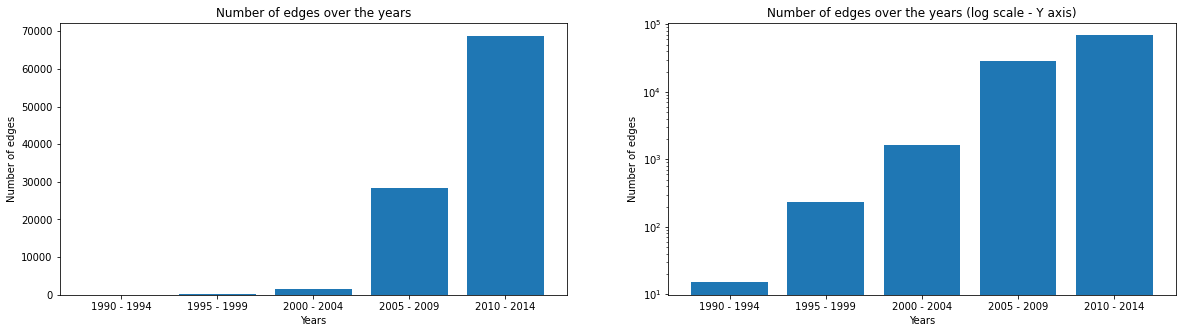

In [102]:
print('   Years     :   Edges   ')
edge_number_histogram = {f'{year_range[0]} - {year_range[1]}':graph_list[i].number_of_edges() for i, year_range  in enumerate(years_range)}
for years,edges in edge_number_histogram.items():
    print(f'{years}  :    {edges}')

fig, axs = plt.subplots(1,2,figsize=(20,5))
for i in range(2):
    axs[i].bar(edge_number_histogram.keys(), edge_number_histogram.values())
    axs[i].set_xlabel("Years")
    axs[i].set_ylabel("Number of edges")
    titel = f'Number of edges over the years'
    if i>0:
        axs[i].set_yscale('log')
        titel += ' (log scale - Y axis)'
    axs[i].set_title(titel)

   Years     :   Nodes   
1990 - 1994  :    21
1995 - 1999  :    256
2000 - 2004  :    1317
2005 - 2009  :    14250
2010 - 2014  :    35122


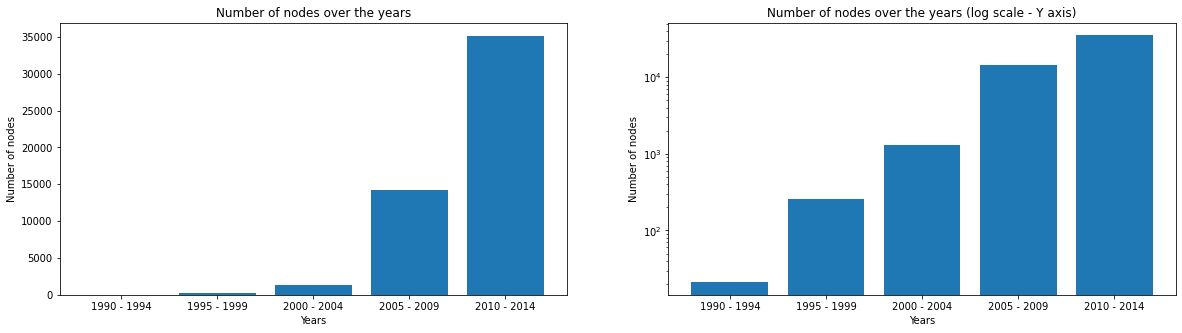

In [103]:
print('   Years     :   Nodes   ')
node_number_histogram = {f'{year_range[0]} - {year_range[1]}':graph_list[i].number_of_nodes() for i, year_range  in enumerate(years_range)}
for years,nodes in node_number_histogram.items():
    print(f'{years}  :    {nodes}')

fig, axs = plt.subplots(1,2,figsize=(20,5))
for i in range(2):
    axs[i].bar(node_number_histogram.keys(), node_number_histogram.values())
    axs[i].set_xlabel("Years")
    axs[i].set_ylabel("Number of nodes")
    titel = f'Number of nodes over the years'
    if i>0:
        axs[i].set_yscale('log')
        titel += ' (log scale - Y axis)'
    axs[i].set_title(titel)

#### Measures, Features and Plotting

<ipython-input-104-79d7f6477531>:5: DeprecationWarning: info is deprecated and will be removed in version 3.0.

  print(nx.info(G_weighted_directed))


MultiDiGraph with 256 nodes and 233 edges


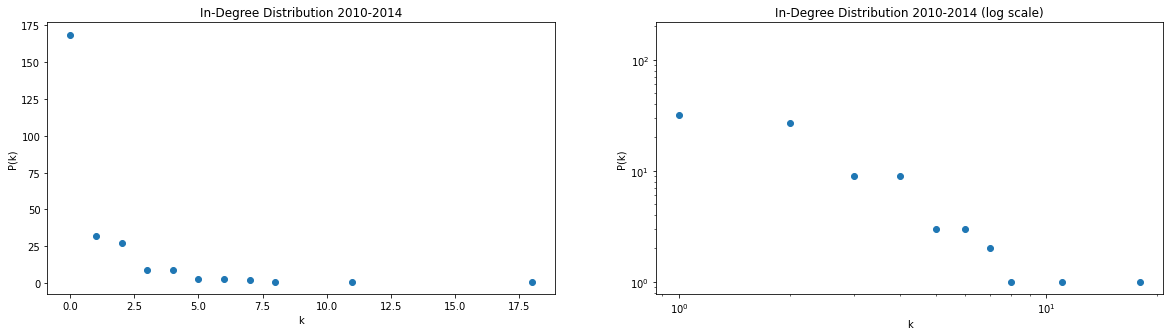

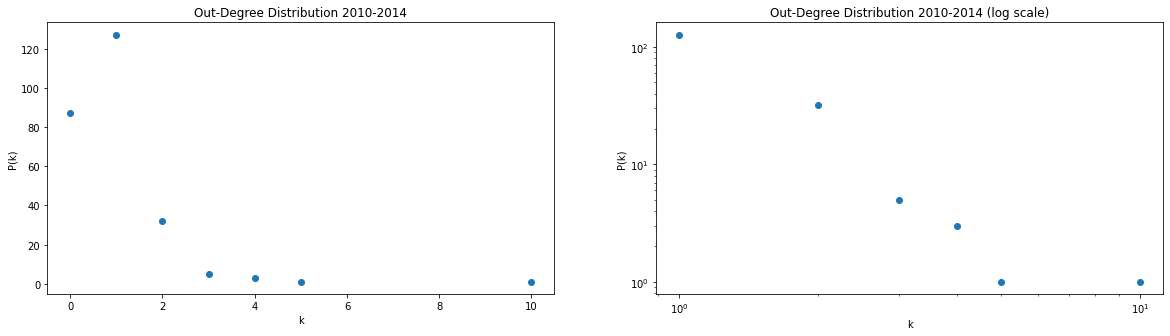

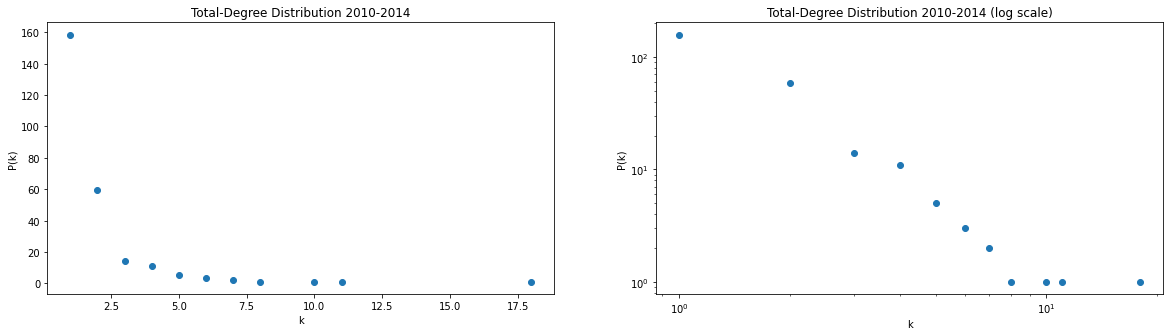

In [104]:
def plot_degree_distribution(num):
    # G_weighted_directed = nx.from_pandas_edgelist(df=df_list[4],source='Investor_Name',target='Company_Name',edge_attr=True,create_using=nx.MultiDiGraph())
    G_weighted_directed = graph_list[num]
    # nodes = pd.DataFrame(list(G_weighted_directed.nodes))
    print(nx.info(G_weighted_directed))
    # degrees = [G_weighted_directed.degree(n) for n in G_weighted_directed.nodes()]
    degree_dict = {'In':G_weighted_directed.in_degree,'Out':G_weighted_directed.out_degree,'Total':G_weighted_directed.degree}
    dic = defaultdict() # key=in/out/total : value=count_deg
    for item in degree_dict.items():
        count_deg = defaultdict(int)
        for node, degree in item[1]:
            count_deg[degree] += 1 / len(item[1])
            count_deg[degree] += 1
        dic[item[0]] = count_deg

    for j,dict in dic.items():
        fig, axs = plt.subplots(1,2,figsize=(20,5))
        for i in range(2):
            axs[i].scatter(dict.keys(), dict.values())
            # mean_k = np.mean([item[0]*item[1] for item in dict.items()])
            # max_k = max(dict.keys())
            # a = np.linspace(1, max_k, len(list(dict.keys())))
            # axs[i].plot(dict.keys(), poisson.pmf(a, mu=5))
            # axs[i].plot(np.linspace(0, max_k, 100), np.exp(np.linspace(0, max_k, 100)))
            # axs[i].plot(np.log(np.linspace(1, max_k*10, 1000000)), np.log(np.exp(np.linspace(1, max_k*10, 1000000))))
            axs[i].set_xlabel("k")
            axs[i].set_ylabel("P(k)")
            titel = f'{j}-Degree Distribution {years_range[4][0]}-{years_range[4][1]}'
            if i>0:
                axs[i].set_yscale('log')
                axs[i].set_xscale('log')
                # mean_k = np.mean([item[0]*item[1] for item in dict.items()])
                # max_k = max(dict.keys())
                # a = np.linspace(1, max_k, max_k)
                # from math import e
                # import math
                # b = [((e**(-mean_k))*(mean_k**i))/(math.factorial(i)) for i in a]
                # axs[i].plot(a,b)
                # from scipy.stats import poisson
                # axs[i].plot(np.linspace(1, max_k, 1000000), poisson.pmf((np.linspace(1, max_k, 1000000)),mu=mean_k))
                titel += ' (log scale)'
            axs[i].set_title(titel)

plot_degree_distribution(1)

In [105]:
from scipy.stats import poisson
# import matplotlib.pyplot as plt
# mu = 0.6
# fig, ax = plt.subplots(1, 1)
# x = np.arange(poisson.ppf(0.01, mu), poisson.ppf(0.99, mu))
# ax.plot(x, poisson.pmf(x, mu), 'bo', ms=8, label='poisson pmf')
# ax.vlines(x, 0, poisson.pmf(x, mu), colors='b', lw=5, alpha=0.5)
poisson.pmf(np.array([4,5]), mu=7)

array([0.09122619, 0.12771667])

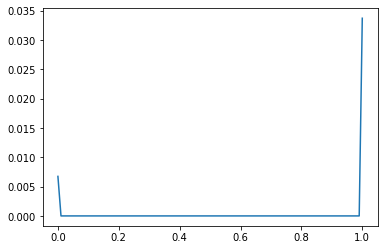

In [106]:
from scipy.stats import poisson
import matplotlib.pyplot as plt
%matplotlib inline 

#generate Poisson distribution with sample size 10000
x = poisson.rvs(mu=3, size=1000)
a = np.linspace(0, 1, 100)
b = poisson.pmf(a, mu=5)

#create plot of Poisson distribution
plt.plot(a,b)


Calculating best minimal value for power law fit
Gamma (Total) = 2.7094613035130446


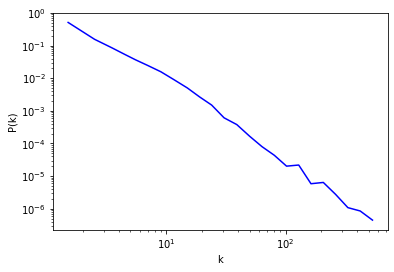

In [107]:
def plot_gamma(num):
    G_weighted_directed = graph_list[num]
    degree_dict = {'In':G_weighted_directed.in_degree,'Out':G_weighted_directed.out_degree,'Total':G_weighted_directed.degree}
    degree_sequence = sorted([d for _, d in degree_dict['Total']],reverse=True)
    figPDF = powerlaw.plot_pdf(degree_sequence,color='b')
    figPDF.set_ylabel(r"P(k)")
    figPDF.set_xlabel(r"k")
    fit = powerlaw.Fit(degree_sequence,discrete=True)
    gamma = fit.power_law.alpha
    print(f"Gamma (Total) = {gamma}")

plot_gamma(4)

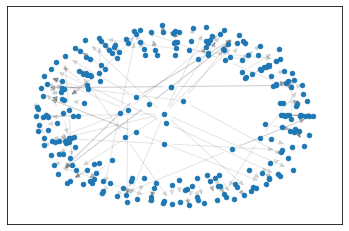

In [108]:
# Plot directional Graph

# G = nx.MultiDiGraph()
# edges = [df_list[3]]
# G = nx.from_pandas_edgelist(df=df_list[1],source='Investor_Name',target='Company_Name',edge_attr=True,create_using=nx.MultiDiGraph())
G = graph_list[1]
pos = nx.spring_layout(G)
nx.draw_networkx_nodes(G, pos, cmap=plt.get_cmap('jet'), node_size = 20)
nx.draw_networkx_edges(G,pos,alpha=0.1)
# nx.draw_networkx_labels(G, pos)
plt.show()

In [109]:
def print_giant_component(num):
    G = nx.from_pandas_edgelist(df_list[num],source='Investor_Name',target='Company_Name', edge_attr=['Company_Market','Raised_Amount_USD'], create_using=nx.Graph())
    print('v')
    if nx.is_connected(G):
      print("Diameter(G)=",nx.diameter(G))
    else:
        print(f'Graph of years {years_dict[num][0]}-{years_dict[num][1]} is unconnected')
        print("Size giant componenet =", len(max(nx.connected_components(G),key=len)))

print_giant_component(1)

v
Graph of years 1995-1999 is unconnected
Size giant componenet = 34


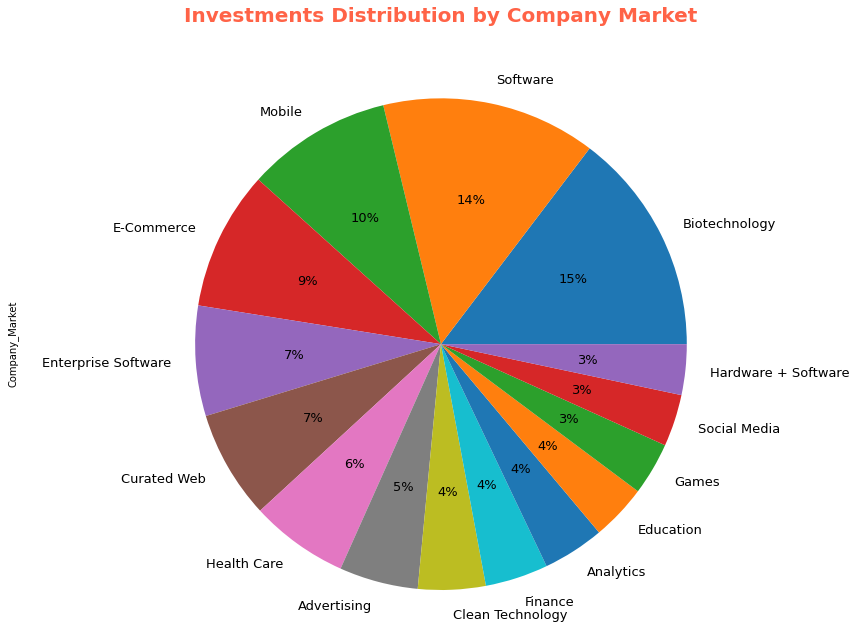

In [110]:
def plot_company_market_distribution(num): 
    df_list[num].Company_Market.value_counts().head(15).plot.pie(figsize=(15,10),autopct='%1.0f%%',fontsize=13)
    plt.title('Investments Distribution by Company Market\n\n', fontsize=20, fontweight='bold',color='tomato')
    plt.axis('equal')

plot_company_market_distribution(4)

Graphs - number of edges
years_range = [(1990, 1994), (1995, 1999), (2000, 2004), (2005,2009), (2010, 2014)]

In [111]:
# def get_in_out_nodes(g, investors:pd.DataFrame, company_name: pd.DataFrame):
#     """
#     Split degrees to companies and investors (inbound, outbound)
#     :param g: graph
#     :param investors: investors DF
#     :param company_name: comapnies DF
#     """
#     all_degrees = g.degree
#     in_nodes = defaultdict(int)
#     out_nodes = defaultdict(int)

#     for company, n_edges in all_degrees:
#         if company in investors.values:
#             out_nodes[company] = n_edges
#         elif company in company_name.values:
#             in_nodes[company] = n_edges

#     print("Invested in companies (inbound)")
#     # print(dict(in_nodes))
#     print(in_nodes)
#     print("\n")
#     print("Investing companies (outbound)")
#     # print(dict(out_nodes))
#     print(out_nodes)
#     return in_nodes, out_nodes

# def avg_degree(nodes:dict):
#     """
#     Calculate the average degree of the nodes in the graph
#     :param nodes: dictionary of node_name(str): degree(int)
#     """
#     return sum([degree for degree in nodes.values()]) / len(nodes)

# g = graph_list[0]
# investing_companies = df_list[0]['Investor_Name']
# invested_companies = df_list[0]['Company_Name']
# inbound, outbound = get_in_out_nodes(g, investing_companies, invested_companies)
# print(avg_degree(inbound))
# print(avg_degree(outbound))


In [112]:
def build_centrality_table(num):    
    G = nx.from_pandas_edgelist(df_list[num],source='Investor_Name',target='Company_Name', edge_attr=['Company_Market','Raised_Amount_USD'], create_using=nx.MultiDiGraph())
    nodes = pd.DataFrame(list(G.nodes))
    #degree_centrality, in_degree_centrality, out_degree_centrality, betweenness_centrality and closeness_centrality
    measures = {'Degree': nx.degree_centrality,'In-Degree': nx.in_degree_centrality,'Out-Degree': nx.out_degree_centrality,'Betweenness': nx.betweenness_centrality,'Closeness': nx.closeness_centrality}

    for name, measure in measures.items():
        if name == 'Betweenness':
            G = nx.from_pandas_edgelist(df_list[num],source='Investor_Name',target='Company_Name', edge_attr=['Company_Market','Raised_Amount_USD'], create_using=nx.DiGraph())
            centrality_dict = measure(G,k=min(len(G.nodes),50000))
            pass
        else:
            centrality_dict = measure(G)
        nodes[name] = nodes[0].apply(lambda x: centrality_dict.get(x, None))
    return nodes

In [113]:
centrality_table = build_centrality_table(1).rename(columns={0: "Company Name"})
centrality_table

,Company Name,Degree,In-Degree,Out-Degree,Betweenness,Closeness
0,CMGI @Ventures,0.007843,0.000000,0.007843,0.000000,0.000000
1,GeoCities,0.023529,0.023529,0.000000,0.000000,0.019216
2,Sequoia Capital,0.011765,0.000000,0.011765,0.000000,0.000000
3,Yahoo!,0.019608,0.015686,0.003922,0.000046,0.011765
4,Kleiner Perkins Caufield & Byers,0.011765,0.000000,0.011765,0.000000,0.000000
...,...,...,...,...,...,...
251,Goldpocket Interactive,0.007843,0.007843,0.000000,0.000000,0.007843
252,Comdisco Ventures,0.003922,0.000000,0.003922,0.000000,0.000000
253,ServiceMaster Home Service Center,0.003922,0.003922,0.000000,0.000000,0.003922
254,New England Partners,0.003922,0.000000,0.003922,0.000000,0.000000


In [114]:
def print_centralization(num,measure):    
    table = centrality_table.sort_values([measure],ascending=False).head(10)[['Company Name',measure]]
    max_centrality = table.max()[1]
    G = nx.from_pandas_edgelist(df_list[num],source='Investor_Name',target='Company_Name', edge_attr=['Company_Market','Raised_Amount_USD'], create_using=nx.DiGraph())
    table['difference'] = max_centrality-table[measure]
    centralization = table['difference'].sum()/((G.number_of_nodes()-1)*(G.number_of_nodes()-2))
    print(f'The centralization is {centralization}')

In [115]:
centrality_table.sort_values(['Degree'],ascending=False).head(10)[['Company Name','Degree']]

,Company Name,Degree
120,Cooking.com,0.070588
104,Answers Corporation,0.043137
21,IDG Capital Partners,0.039216
55,Shopzilla,0.031373
98,Salesforce,0.027451
33,iPrint,0.027451
1,GeoCities,0.023529
190,ACTIVE Network,0.023529
168,OurHouse,0.023529
16,PowerDsine,0.019608


In [116]:
print_centralization(1,'Degree')

The centralization is 5.812422236147817e-06


In [117]:
centrality_table.sort_values(['In-Degree'],ascending=False).head(10)[['Company Name','In-Degree']]

,Company Name,In-Degree
120,Cooking.com,0.070588
104,Answers Corporation,0.043137
55,Shopzilla,0.031373
98,Salesforce,0.027451
33,iPrint,0.027451
190,ACTIVE Network,0.023529
1,GeoCities,0.023529
168,OurHouse,0.023529
154,Studio Systems,0.019608
246,Trivnet,0.019608


In [118]:
print_centralization(3,'In-Degree')

The centralization is 1.950935450716879e-09


In [119]:
centrality_table.sort_values(['Out-Degree'],ascending=False).head(10)[['Company Name','Out-Degree']]

,Company Name,Out-Degree
21,IDG Capital Partners,0.039216
172,Trident Capital,0.019608
13,Smedvig Capital,0.015686
114,Intel Capital,0.015686
169,Gabriel Venture Partners,0.015686
10,Flatiron Partners,0.011765
2,Sequoia Capital,0.011765
4,Kleiner Perkins Caufield & Byers,0.011765
86,SV Angel,0.011765
127,Tredegar Investments,0.011765


In [120]:
print_centralization(3,'Out-Degree')

The centralization is 1.120339169718604e-09


In [121]:
centrality_table.sort_values(['Betweenness'],ascending=False).head(10)[['Company Name','Betweenness']]

,Company Name,Betweenness
3,Yahoo!,0.000046
0,CMGI @Ventures,0.000000
176,Dynamics Direct,0.000000
163,Group Arnault,0.000000
164,Netflix,0.000000
165,Morningstar,0.000000
166,Nokia Ventures,0.000000
167,Ace Hardware,0.000000
168,OurHouse,0.000000
169,Gabriel Venture Partners,0.000000


In [122]:
print_centralization(3,'Betweenness')

The centralization is 2.053296061797604e-12


In [123]:
centrality_table.sort_values(['Closeness'],ascending=False).head(10)[['Company Name','Closeness']]

,Company Name,Closeness
104,Answers Corporation,0.043137
120,Cooking.com,0.039216
98,Salesforce,0.027451
33,iPrint,0.027451
168,OurHouse,0.023529
55,Shopzilla,0.019608
154,Studio Systems,0.019608
16,PowerDsine,0.019608
246,Trivnet,0.019608
1,GeoCities,0.019216


In [124]:
print_centralization(3,'Closeness')

The centralization is 8.518440928377661e-10


Average clustering coefficient for random graph is 0.00022496130845747254


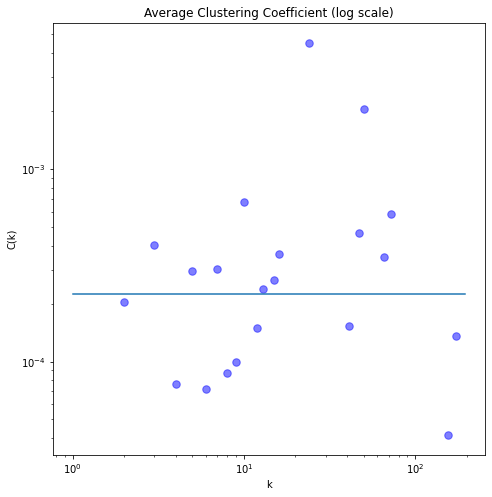

In [125]:
def plot_clustering_coefficient(num):
    G = nx.from_pandas_edgelist(df_list[num],source='Investor_Name',target='Company_Name', edge_attr=['Company_Market','Raised_Amount_USD'], create_using=nx.DiGraph())
    clustering_dict = defaultdict(list)
    for node in G.nodes():
        k = G.degree(node)
        clustering_dict[k].append(nx.clustering(G,node))
    k_list = sorted(clustering_dict.keys())
    clustering_list = []
    for k in k_list:
        clustering_list.append(np.mean(clustering_dict[k])) 
    fig = plt.figure(figsize=(6,6))
    axes = fig.add_axes([1,1,1,1])
    axes.loglog(k_list,clustering_list,'b.', markersize=15, alpha=0.5)
    axes.set_xlabel('k')
    axes.set_ylabel('C(k)')
    axes.set_title('Average Clustering Coefficient (log scale)')
    # fig.savefig(f'plots/clustering_coefficient_{num}.png', bbox_inches='tight')
    N = G.number_of_nodes()
    L = G.number_of_edges()
    p = (2*L)/(N*(N-1))
    print('Average clustering coefficient for random graph is {}'.format(p))
    axes.plot(k_list,[p]*len(k_list))
    plt.show()
    
plot_clustering_coefficient(3)

In [126]:
def fit_func(x,a,mu):
    return (a*x)**mu

<ipython-input-127-69dc74d632d1>:3: DeprecationWarning: k_nearest_neighbors function is deprecated and will be removed in v3.0.
Use `average_degree_connectivity` instead.
  knn_dict = nx.k_nearest_neighbors(G)


Assortative graph with mu 0.189


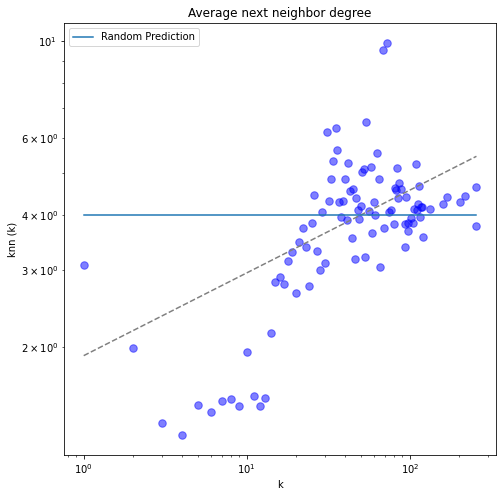

In [127]:
def plot_knn(num):
    G = graph_list[num]
    knn_dict = nx.k_nearest_neighbors(G)
    k_lst = sorted(knn_dict.keys())
    knn_lst = []
    for k in k_lst:
        knn_lst.append(knn_dict[k]) 
    fig = plt.figure(figsize=(6,6))
    axes = fig.add_axes([1,1,1,1])
    axes.loglog(k_lst,knn_lst,'b.', markersize=15, alpha=0.5)
    axes.set_xlabel('k')
    axes.set_ylabel('knn (k)')
    axes.set_title('Average next neighbor degree')
    try:
        popt, pcov = curve_fit(fit_func, np.array(k_lst), np.array(knn_lst),maxfev=5000)
        axes.loglog(np.array(k_lst), fit_func(np.array(k_lst), *popt), '--', c='gray')
        axes.plot(np.array(k_lst), np.array([2*G.number_of_edges()/G.number_of_nodes()]*len(k_lst)),label='Random Prediction')
        if popt[1] > 0:
            print(f'Assortative graph with mu {round(popt[1],3)}')
        elif popt[1] < 0:
            print(f'Disassortative graph with mu {round(popt[1],3)}')
        else:
            print(f'Neutral graph (mu = 0)')
    except:
        pass
    # fig.savefig('plots/knn.png', bbox_inches='tight')
    plt.legend()
    plt.show()
    
plot_knn(3)

<ipython-input-128-44c7040901e9>:3: DeprecationWarning: k_nearest_neighbors function is deprecated and will be removed in v3.0.
Use `average_degree_connectivity` instead.
  knn_dict = nx.k_nearest_neighbors(G,weight = 'Raised_Amount_USD')
<ipython-input-126-f04d1d35b1eb>:2: RuntimeWarning: invalid value encountered in power
  return (a*x)**mu
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


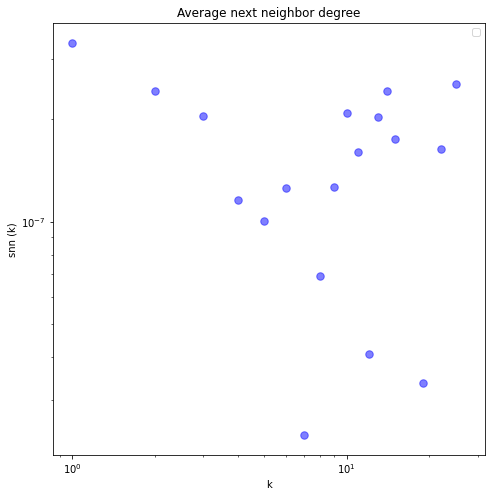

In [128]:
def plot_snn(num):
    G = graph_list[num]
    knn_dict = nx.k_nearest_neighbors(G,weight = 'Raised_Amount_USD')
    k_lst = sorted(knn_dict.keys())
    snn_lst = []
    for k in k_lst:
        snn_lst.append(knn_dict[k]) 
    fig = plt.figure(figsize=(6,6))
    axes = fig.add_axes([1,1,1,1])
    axes.loglog(k_lst,snn_lst,'b.', markersize=15, alpha=0.5)
    axes.set_xlabel('k')
    axes.set_ylabel('snn (k)')
    axes.set_title('Average next neighbor degree')
    try:
        popt, pcov = curve_fit(fit_func, np.array(k_lst), np.array(snn_lst),maxfev=5000)
        print(popt)
        axes.loglog(np.array(k_lst), fit_func(np.array(k_lst), *popt), '--', c='gray')
        axes.plot(np.array(k_lst), np.array([2*G.number_of_edges()/G.number_of_nodes()]*len(k_lst)),label='Random Prediction')
        if popt[1] > 0:
            print(f'Assortative graph with mu {round(popt[1],3)}')
        elif popt[1] < 0:
            print(f'Disassortative graph with mu {round(popt[1],3)}')
        else:
            print(f'Neutral graph (mu = 0)')
    except:
        pass
    # fig.savefig('plots/knn.png', bbox_inches='tight')
    plt.legend()
    plt.show()
    
plot_snn(2)

In [129]:
def print_degree_correlation_coefficient(num):
    G = graph_list[num]
    calc = nx.degree_pearson_correlation_coefficient(G,x='in', y='in', weight='Raised_Amount_USD', nodes=None)
    if calc > 0:
        print(f'Assortative graph with r = {round(calc,3)}')
    elif calc < 0:
        print(f'Disassortative graph with r = {round(calc,3)}')
    else:
        print(f'Neutral graph (r = 0)')

print_degree_correlation_coefficient(2)

Neutral graph (r = 0)


c:\Program Files\Python39\lib\site-packages\scipy\stats\_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


 The average weight is 10730511.609 USD


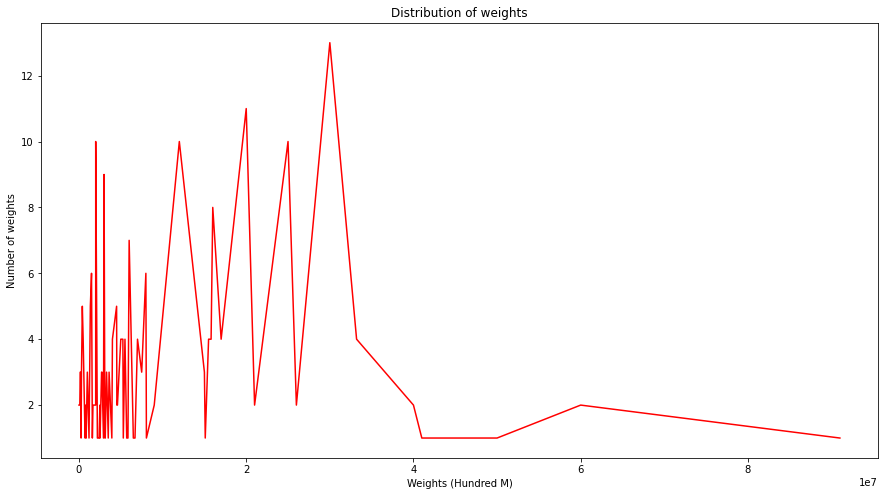

In [130]:
def plot_weight_dist(num):
    G = graph_list[num]
    weight_list = sorted(list((nx.get_edge_attributes(G,'Raised_Amount_USD').values())))
    weight_dict = defaultdict(int)
    for w in weight_list:
        weight_dict[w] += 1
    weights = []
    counts = []
    for weight,cnt in weight_dict.items():
        weights.append(weight)
        counts.append(cnt)
    plt.figure(figsize=(15,8))
    plt.xlabel("Weights (Hundred M)")
    plt.ylabel("Number of weights")
    plt.title(f'Distribution of weights')
    plt.plot(weights,counts,c='r')
    
    avg_w=0
    for i in range(len(weights)):
        avg_w+=weights[i]*counts[i]/sum(counts)
    print(f' The average weight is {round(avg_w,3)} USD')
    
plot_weight_dist(1)
    

Average distance is 3.555
Maximum distance is 10


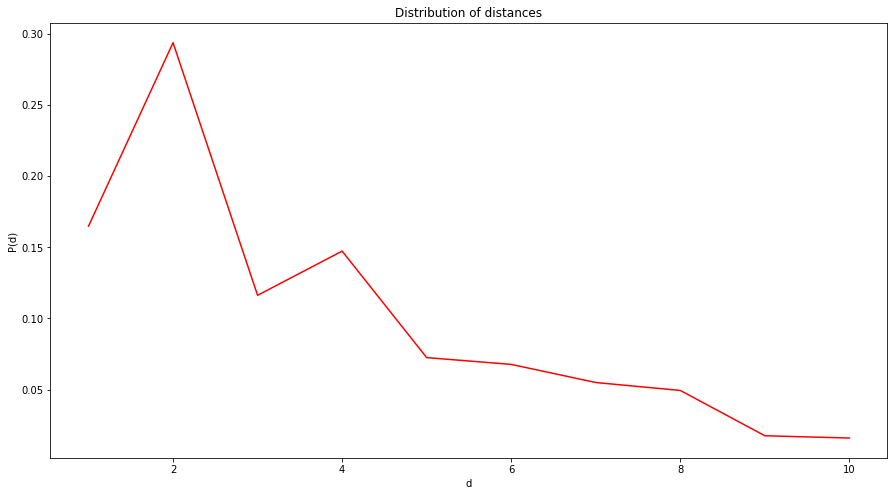

In [131]:
def plot_distance_dist(num):
    G = nx.from_pandas_edgelist(df_list[num],source='Investor_Name',target='Company_Name', edge_attr=['Company_Market','Raised_Amount_USD'], create_using=nx.Graph())
    shortest_path = nx.shortest_path_length(G)
    distance_dict = defaultdict(int)

    for i in shortest_path:
        for j in i[1].values():
            if j > 0:
                distance_dict[j] += 1
    distances = []
    counts = []
    for item in distance_dict.items():
        distances.append(item[0])
        counts.append(item[1]/np.sum(list(distance_dict.values())))

    plt.figure(figsize=(15,8))
    plt.xlabel("d")
    plt.ylabel("P(d)")
    plt.title(f'Distribution of distances')
    plt.plot(distances,counts,c='r')

    avg_d=0
    for i in range(len(distances)):
        avg_d+=distances[i]*counts[i]/sum(counts)
    print(f'Average distance is {round(avg_d,3)}')
    print(f'Maximum distance is {max(distances)}')
    
plot_distance_dist(1)

In [132]:
def Communitys(num):
    G = nx.from_pandas_edgelist(df_list[num],source='Investor_Name',target='Company_Name', edge_attr=['Company_Market','Raised_Amount_USD'], create_using=nx.Graph())
    
    #Using the Kernighan–Lin algorithm
    KL_communities_generator = community.kernighan_lin_bisection(G,max_iter=10)
    #Measuring partitions by modularity
    print (community.modularity(G, KL_communities_generator))

    #Communities with modularity
    greedy_mod=greedy_modularity_communities(G)
    print (community.modularity(G, greedy_mod))
    
    #Giravn _newman communities:
    GN_communities_generator = c.girvan_newman(G)
    for i in range(10):
        communities= next(GN_communities_generator)

    GN_comm_sets = sorted(map(sorted, communities))
    #Measuring partitions by modularity
    print (community.modularity(G, GN_comm_sets))
    
    #Louvain communities:
    partition = community_louvain.best_partition(G)
    
    d_for_getting_num_of_com={}
    for x in partition:
        if partition[x] not in d_for_getting_num_of_com:
            d_for_getting_num_of_com[partition[x]]=1
    empty_lists = [ [] for l in range(len(d_for_getting_num_of_com) ) ]
    
    for node in partition:
        empty_lists[partition[node]].append(node)
    print (community.modularity(G,empty_lists))

    return KL_communities_generator, greedy_mod, GN_comm_sets, partition

#print(Communitys(2))

Bipartite Graph - Connect investors and companies
Investor Projection: There is an edge between two investors if they invested in the same company
Company Projection: There is an edge between two companies if they have the same investor


In [133]:
#
companies_edges = []
investors_edges = []
all_edges = []
for df in df_list:
    companies = defaultdict(set)
    investors = defaultdict(set)
    edges = []
    for index, row in df.iterrows():
        companies[row['Company_Name']].add(row['Investor_Name'])
        investors[row['Investor_Name']].add(row['Company_Name'])
        # add to edges a tuple of (company, investor, {weight: amout_usd})
        edges.append((row['Company_Name'], row['Investor_Name'], {"Weight": row['Raised_Amount_USD']} ))
        
    attr_dic = {x:y for x, y in zip(df['Company_Name'], df['Company_Market'])}
    attr_dic_fixed = {x:'Investors' for x in df['Investor_Name']}
    attr_dic_fixed.update(attr_dic)
    nx.set_node_attributes(graph, attr_dic_fixed, name="Sector")
    companies_edges.append(companies)
    investors_edges.append(investors)
    all_edges.append(edges)
# for i,df in enumerate(df_list):
#     
print(all_edges[0])
# print(companies_edges)
# print(investors_edges)

NameError: name 'graph' is not defined

#### Make gephi file from edge list

In [ ]:
# graph = nx.Graph()
# graph.add_edges_from(all_edges[1])
#gs = [make_graph(df) for df in df_list]
#gs2 = [make_companies_graph(df) for df in df_list]
gs3 = [make_investors_graph(df) for df in df_list]
[nx.write_gexf(gs3[i], f"GephiInvestors{i}.gexf") for i in range(len(gs3))]

[None, None, None, None, None]

### Advanced analysis

Can we predict from the network if a start up will succeed or fail?

##### Preprocess dataset

In [166]:
startup_data = pd.read_csv("data/startup_data.csv", infer_datetime_format=True) # This has american startups
startup_data = startup_data[['name', 'founded_at', 'closed_at']]
startup_data['name'] = startup_data.name.apply(lambda x: str(x).lower())
startup_data['founded_at'] = startup_data.founded_at.apply(lambda x: str(x).split("/")[-1] if x is not None else None) # leave only year
startup_data['closed_at'] = startup_data.closed_at.apply(lambda x: str(x).split("/")[-1] if x is not None else None)
company_names = list(map(lambda x: str(x).lower(), original_df["Company_Name"].unique()))
startup_names = set(list(map(lambda x: str(x).lower(), startup_data['name'].unique())))
print(startup_data.head())

years_range = [(1990, 1994), (1995, 1999), (2000, 2004), (2005,2009), (2010, 2014)]
#startup_df_list = [startup_data[(startup_data['founded_at'] <= year_range[1]) & (startup_data['founded_at'] >= year_range[0])] for year_range in years_range]
count = 0
fail_count = 0
for company in company_names:
    if company in startup_names:
        row = startup_data.loc[startup_data['name'] == company]
        
        if row.values[0][2] != "nan":
            print(f"Failed - {row.values[0][0]}, {row.values[0][1]}, {row.values[0][2]}")
            fail_count +=1
        else:
            print(f"{row.values[0][0]}, {row.values[0][1]}, {row.values[0][2]}")
            
        count +=1
print(fail_count)
print(count)

                name founded_at closed_at
0        bandsintown       2007       NaN
1          tricipher       2000       NaN
2              plixi       2009       NaN
3  solidcore systems       2002       NaN
4     inhale digital       2010      2012
anystream, 2000, nan
Failed - anystream, 2000, nan
navic networks, 2000, nan
Failed - navic networks, 2000, nan
action engine, 2000, nan
Failed - action engine, 2000, nan
myrio, 1999, 2012
Failed - myrio, 1999, 2012
snapnames, 2000, nan
Failed - snapnames, 2000, nan
boomi, 2000, nan
Failed - boomi, 2000, nan
id analytics, 2002, nan
Failed - id analytics, 2002, nan
ironport systems, 2000, nan
Failed - ironport systems, 2000, nan
viacor, 1999, 2011
Failed - viacor, 1999, 2011
mr. youth, 2002, nan
Failed - mr. youth, 2002, nan
plaxo, 2002, nan
Failed - plaxo, 2002, nan
gotuit, 2000, nan
Failed - gotuit, 2000, nan
metreos corporation, 2001, nan
Failed - metreos corporation, 2001, nan
dilithium networks, 2001, 2012
Failed - dilithium networks,

In [ ]:
##############################################################
####################### Do Not Delete ########################
##############################################################

# # Make the gephi's files
# graph_list_for_attr = []
# for i,df in enumerate(df_list):
#     attr_dic = {x:y for x, y in zip(df['Company_Name'], df['Company_Market'])}
#     attr_dic_fixed = {x:'Investors' for x in df['Investor_Name']}
#     attr_dic_fixed.update(attr_dic)
#     graph = nx.from_pandas_edgelist(df,source='Investor_Name',target='Company_Name', edge_attr=['Company_Market','Raised_Amount_USD'], create_using=nx.MultiDiGraph())
#     nx.set_node_attributes(graph, attr_dic_fixed, name="Sector")
#     graph_list_for_attr.append(graph)
#     nx.write_gexf(graph, f"Gephi{i}.gexf")